## Figure 3

Perturbation sample diversity

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(ComplexHeatmap))

source("viz_themes.R")
source("plotting_functions.R")
source("data_functions.R")

In [2]:
output_figure_base <- file.path("figures", "figure3")
extensions <- c(".png", ".pdf")

### Panel A - UMAP

In [3]:
results_dir <- file.path("../1.Data-exploration/Profiles_level4/")

In [4]:
cp_df <- load_embeddings_data(assay="cellpainting", results_dir = results_dir)
l1000_df <- load_embeddings_data(assay="l1000", results_dir = results_dir)

In [5]:
# Create compounds to highlight
moa_targets <- c(
    "plk inhibitor" = "PLK inhibitor",
    "proteasome inhibitor" = "Proteasome inhibitor",
    "cdk inhibitor" = "CDK inhibitor",
    "tubulin inhibitor" = "Tubulin inhibitor",
    "hsp inhibitor" = "HSP inhibitor",
    "xiap inhibitor" = "XIAP inhibitor",
    "other" = "Other"
)

moa_colors <- c(
    "plk inhibitor" = "#332288",
    "proteasome inhibitor" = "#117733",
    "cdk inhibitor" = "#88CCEE",
    "tubulin inhibitor" = "#CC6677",
    "hsp inhibitor" = "#FF9A00",
    "xiap inhibitor" = "#882255",
    "other" = "grey"
)

moa_targets_size_values <- c(rep(1.5, length(moa_targets) -1), 0.1)
names(moa_targets_size_values) <- names(moa_targets)

moa_targets_alpha_values <- c(rep(0.5, length(moa_targets) - 1), 0.1)
names(moa_targets_alpha_values) <- names(moa_targets)

cp_df <- cp_df %>% dplyr::mutate(highlight_moa = tolower(moa))
cp_df$highlight_moa[!(cp_df$highlight_moa %in% names(moa_targets))] <- "other"

l1000_df <- l1000_df %>% dplyr::mutate(highlight_moa = tolower(moa))
l1000_df$highlight_moa[!(l1000_df$highlight_moa %in% names(moa_targets))] <- "other"

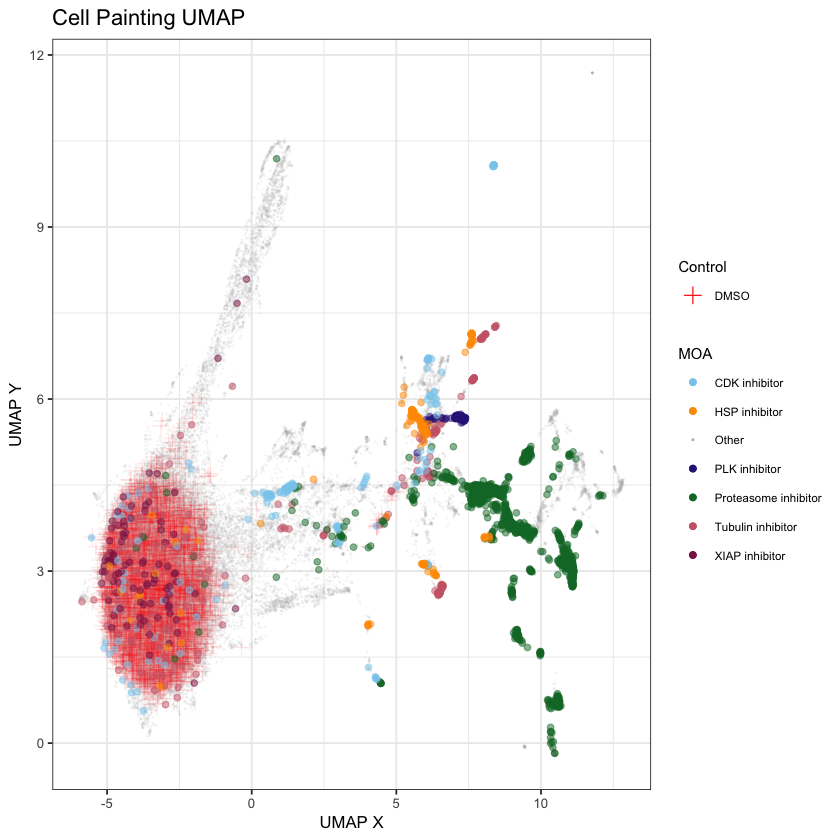

In [6]:
panel_a_gg <- (
    ggplot(data = NULL, aes(x = UMAP_0, y = UMAP_1, color = highlight_moa, size = highlight_moa, alpha = highlight_moa))
    + geom_point(data = cp_df %>% dplyr::filter(highlight_moa == "other"))
    + geom_point(data = cp_df %>% dplyr::filter(dmso_label == "DMSO"), size = 3, color = "red", aes(shape = dmso_label))
    + geom_point(data = cp_df %>% dplyr::filter(highlight_moa != "other"))
    + ggtitle("Cell Painting UMAP")
    + figure_theme
    + scale_size_manual("MOA", labels = moa_targets, values = moa_targets_size_values)
    + scale_alpha_manual("MOA", values = moa_targets_alpha_values)
    + scale_color_manual("MOA", labels = moa_targets, values = moa_colors)
    + scale_shape_manual("Control", values = c("DMSO" = 3))
    + xlab("UMAP X")
    + ylab("UMAP Y")
    + guides(alpha = FALSE)
)

panel_a_gg

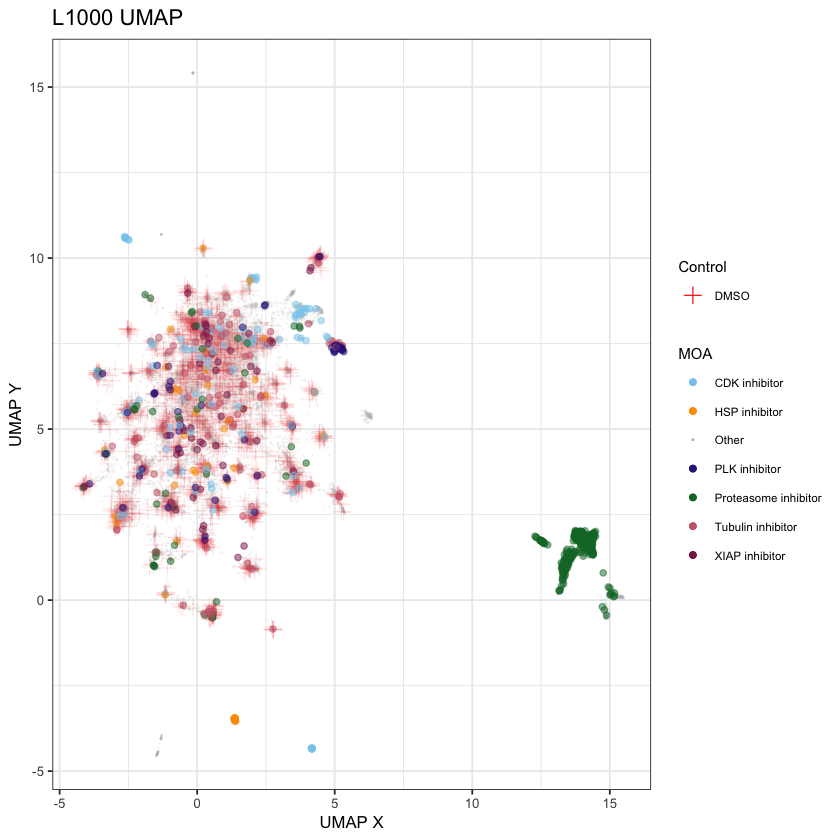

In [7]:
panel_b_gg <- (
     ggplot(data = NULL, aes(x = UMAP_0, y = UMAP_1, color = highlight_moa, size = highlight_moa, alpha = highlight_moa))
    + geom_point(data = l1000_df %>% dplyr::filter(highlight_moa == "other"))
    + geom_point(data = l1000_df %>% dplyr::filter(dmso_label == "DMSO"), size = 3, color = "red", aes(shape = dmso_label))
    + geom_point(data = l1000_df %>% dplyr::filter(highlight_moa != "other"))
    + ggtitle("L1000 UMAP")
    + figure_theme
    + scale_size_manual("MOA", labels = moa_targets, values = moa_targets_size_values)
    + scale_alpha_manual("MOA", values = moa_targets_alpha_values)
    + scale_color_manual("MOA", labels = moa_targets, values = moa_colors)
    + scale_shape_manual("Control", values = c("DMSO" = 3))
    + xlab("UMAP X")
    + ylab("UMAP Y")
    + guides(alpha = FALSE)
)

panel_b_gg

### Heatmap panels

In [8]:
# Load level 5 consensus signatures
consensus_dir <- file.path("..", "1.Data-exploration", "Consensus")

cp_df <- load_consensus_signatures(assay = "cellpainting", data_dir = consensus_dir)
l1000_df <- load_consensus_signatures(assay = "l1000", data_dir = consensus_dir)

### Panel C

In [9]:
cp_subset_df <- cp_df %>%
    dplyr::filter((Metadata_dose_recode >= 6) | (pert_iname == "dmso"))

cp_corr_df <- cp_subset_df %>%
    dplyr::select(starts_with(c("Cells", "Cytoplasm", "Nuclei"))) %>%
    as.matrix() %>%
    t() %>%
    Hmisc::rcorr(type = "spearman")

cp_corr_df <- cp_corr_df$r

cp_subset_metadata_df <- cp_subset_df %>%
    dplyr::select(Metadata_dose_recode, pert_iname, moa) %>%
    dplyr::mutate(id_number = row_number()) %>%
    dplyr::mutate(dmso_label = "DMSO")

cp_subset_metadata_df$dmso_label[cp_subset_metadata_df$pert_iname != "dmso"] = "compound"

cp_subset_metadata_df <- cp_subset_metadata_df %>% dplyr::mutate(highlight_moa = tolower(moa))
cp_subset_metadata_df$highlight_moa[!(cp_subset_metadata_df$highlight_moa %in% names(moa_targets))] <- "other"

dim(cp_corr_df)

[1] 2889 2889

In [10]:
panel_c_gg <- grid::grid.grabExpr(
    draw(
        Heatmap(
            cp_corr_df,

            column_title = "Cell Painting consensus signatures (10 uM)",

            heatmap_legend_param = list(
                    title = "Spearman\ncorrelation",
                    color_bar = "continuous",
                    col_fun = legend_scale_cols,
                    title_gp = gpar(fontsize = lgd_title_fontsize),
                    title_position = "topleft",
                    labels_gp = gpar(fontsize = lgd_label_fontsize),
                    legend_height = unit(3, "cm")
            )
        )
    )
)

### Panel D

In [11]:
l1000_subset_df <- l1000_df %>%
    dplyr::filter((dose >= 6) | (pert_iname == "dmso"))

l1000_corr_df <- l1000_subset_df %>%
    dplyr::select(ends_with("at")) %>%
    as.matrix() %>%
    t() %>%
    Hmisc::rcorr(type = "spearman")

l1000_corr_df <- l1000_corr_df$r

l1000_subset_metadata_df <- l1000_subset_df %>%
    dplyr::select(dose, pert_iname, moa) %>%
    dplyr::mutate(id_number = row_number()) %>%
    dplyr::mutate(dmso_label = "DMSO")

l1000_subset_metadata_df$dmso_label[l1000_subset_metadata_df$pert_iname != "dmso"] = "compound"

l1000_subset_metadata_df <- l1000_subset_metadata_df %>% dplyr::mutate(highlight_moa = tolower(moa))
l1000_subset_metadata_df$highlight_moa[!(l1000_subset_metadata_df$highlight_moa %in% names(moa_targets))] <- "other"

dim(l1000_corr_df)

[1] 2482 2482

In [12]:
panel_d_gg <- grid::grid.grabExpr(
    draw(
        Heatmap(
            l1000_corr_df,
            
            column_title = "L1000 consensus signatures (10 uM)",

            heatmap_legend_param = list(
                    title = "Spearman\ncorrelation",
                    color_bar = "continuous",
                    col_fun = legend_scale_cols,
                    title_gp = gpar(fontsize = lgd_title_fontsize),
                    title_position = "topleft",
                    labels_gp = gpar(fontsize = lgd_label_fontsize),
                    legend_height = unit(3, "cm")
            )
        )
    )
)

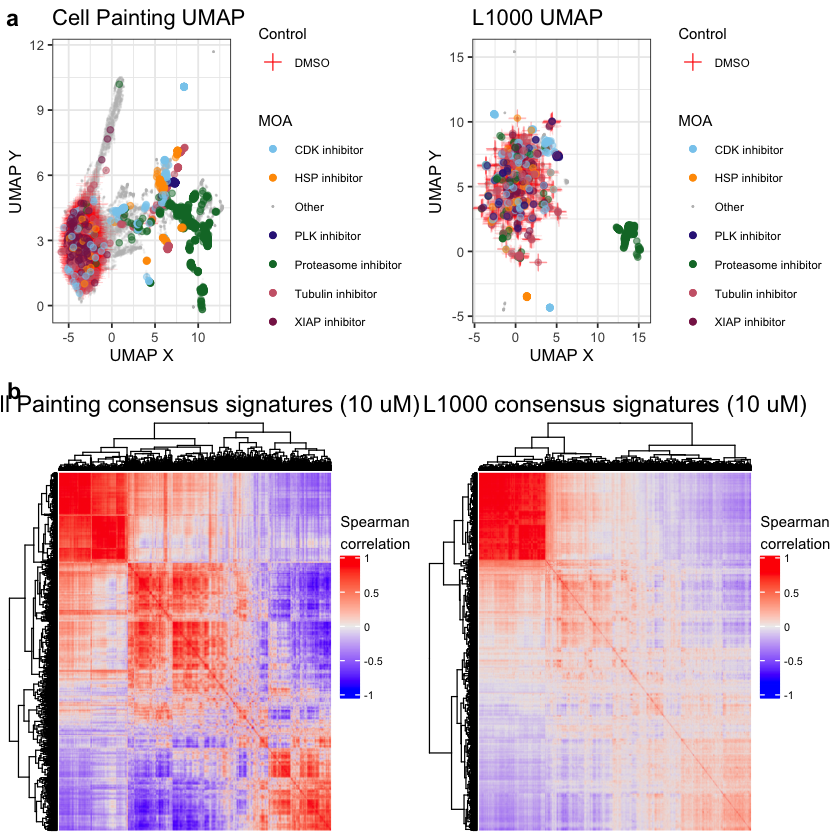

In [13]:
heatmap_panels <- cowplot::plot_grid(
    panel_c_gg,
    panel_d_gg,
    ncol = 2,
    labels = c("b", "")
)

figure3_gg <- cowplot::plot_grid(
    cowplot::plot_grid(
        panel_a_gg,
        panel_b_gg,
        ncol = 2,
        labels = c("a", "")
    ),
    heatmap_panels,
    rel_heights = c(0.8, 1),
    ncol = 1
)

figure3_gg

In [14]:
for (extension in extensions) {
    output_file <- paste0(output_figure_base, extension)
    cowplot::save_plot(output_file, figure3_gg, base_width = 11, base_height = 10, dpi = 500)
}